# COW PATCHES DETECTION INFERENCE PIPELINE

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import BeitModel, BeitConfig
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [4]:
class BeitForFineTuning(nn.Module):
    def __init__(self, num_classes):
        super(BeitForFineTuning, self).__init__()
        config = BeitConfig.from_pretrained('microsoft/beit-base-patch16-224')
        self.beit = BeitModel.from_pretrained('microsoft/beit-base-patch16-224', config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, x):
        # Forward pass through the DeiT model
        output = self.beit(x)
        # Only consider the output of the [CLS] token (first token)
        cls_output = output.last_hidden_state[:, 0, :]
        # Forward pass through the classifier
        logits = self.classifier(cls_output)
        return logits

# Instantiate the model
num_classes = 46  # Number of classes in your dataset
beit = BeitForFineTuning(num_classes)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beit.to(device)

# Print the model architecture
beit

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

BeitForFineTuning(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate

In [5]:
# Define the path to the folder containing the test images
# Replace with your path
test_data_path = "/kaggle/input/open-cow-2020/10m32xl88x2b61zlkkgz3fml17/identification/images/test" 

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),           # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[1, 1, 1])  # Normalize the images
])

# Load the test dataset using ImageFolder
test_dataset = ImageFolder(root=test_data_path, transform=transform)

# Define the dataloader for the test dataset
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Replace with your path to the model
# Setup GPU if available
beit.load_state_dict(torch.load("/kaggle/input/vit-model/beit_model.pth", map_location=torch.device('cpu')))
beit.to(device)
beit.eval()

# Make predictions on the test data
predictions = []
image_filenames = []

with torch.no_grad():
    for images, filenames in tqdm(test_dataloader):
        images = images.to(device)
        outputs = beit(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        image_filenames.extend(filenames)

100%|██████████| 16/16 [03:06<00:00, 11.63s/it]


Accuracy: 0.9597


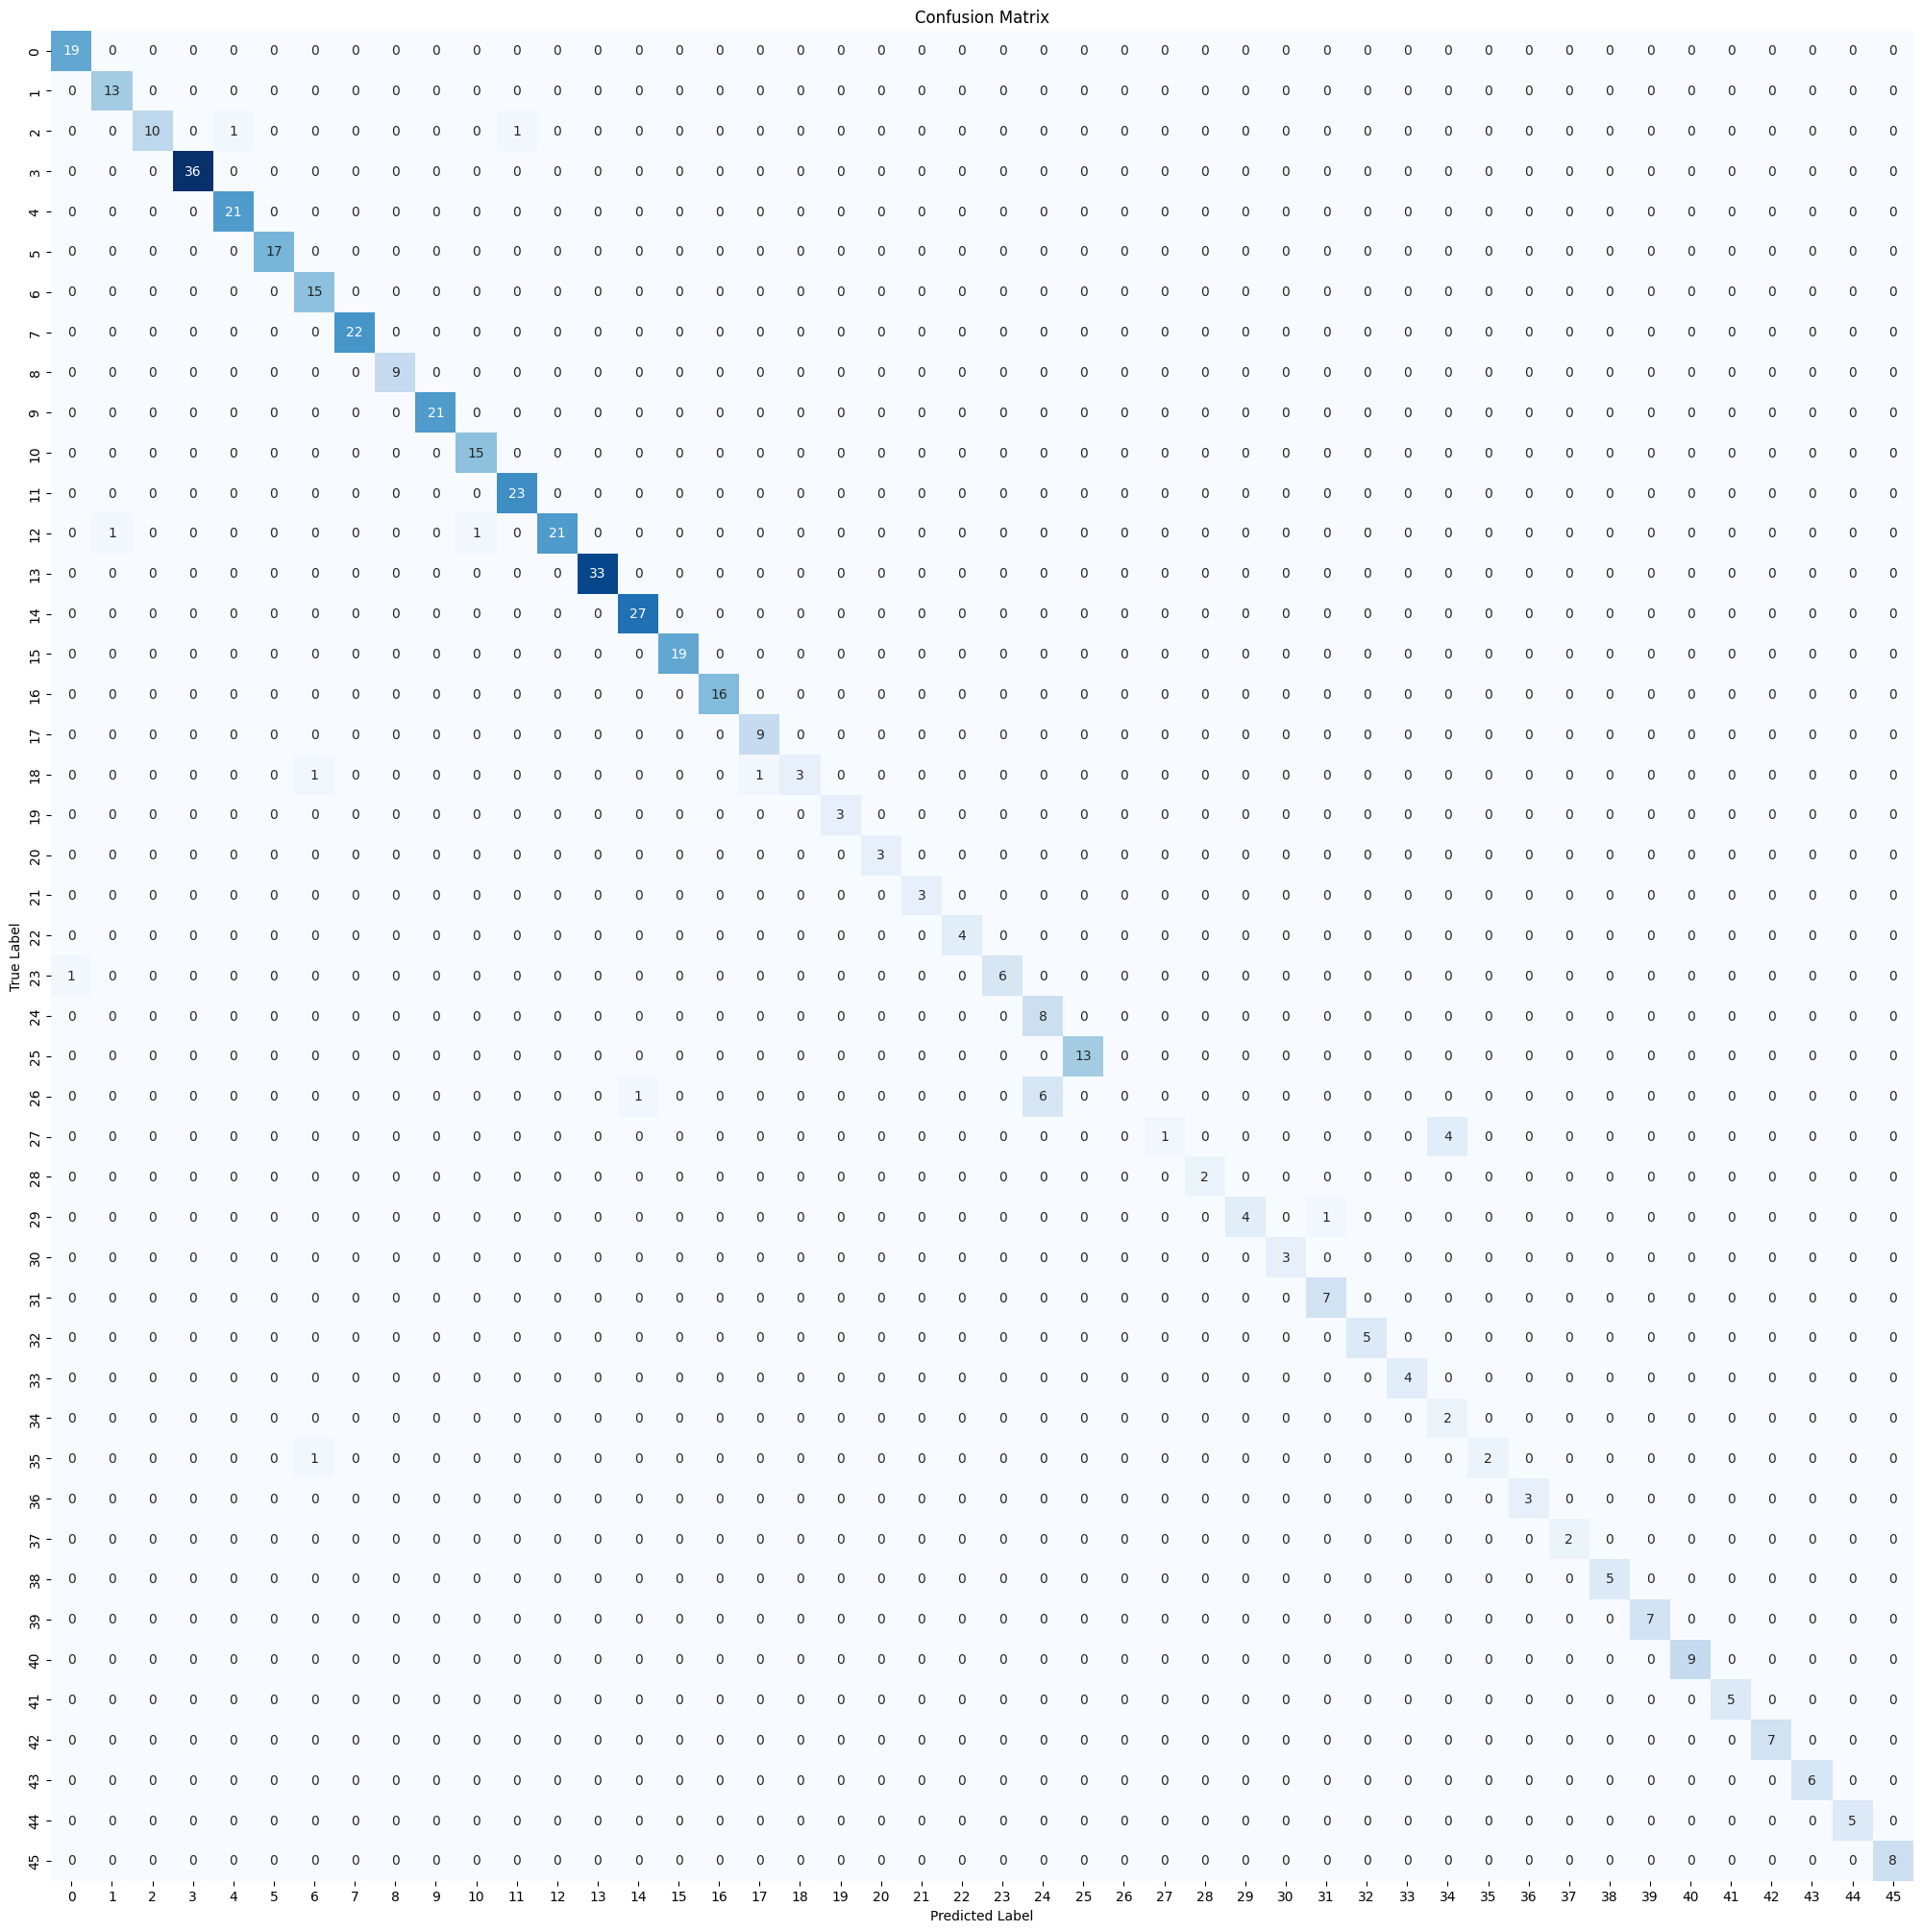

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
labels = np.array([label for _, label in test_dataset])

# Calculate accuracy score
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot confusion matrix using heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:
rep = pd.DataFrame(classification_report(labels, predictions, output_dict = True))
rep.to_csv("BeiT_Classification_Report_Test.csv")
rep

,0,1,2,3,4,5,6,7,11,12,...,30,31,35,42,43,44,45,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.96875,0.913043,0.96875
recall,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.96875,0.913043,0.96875
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.96875,0.913043,0.96875
support,1.0,3.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.96875,32.000000,32.00000


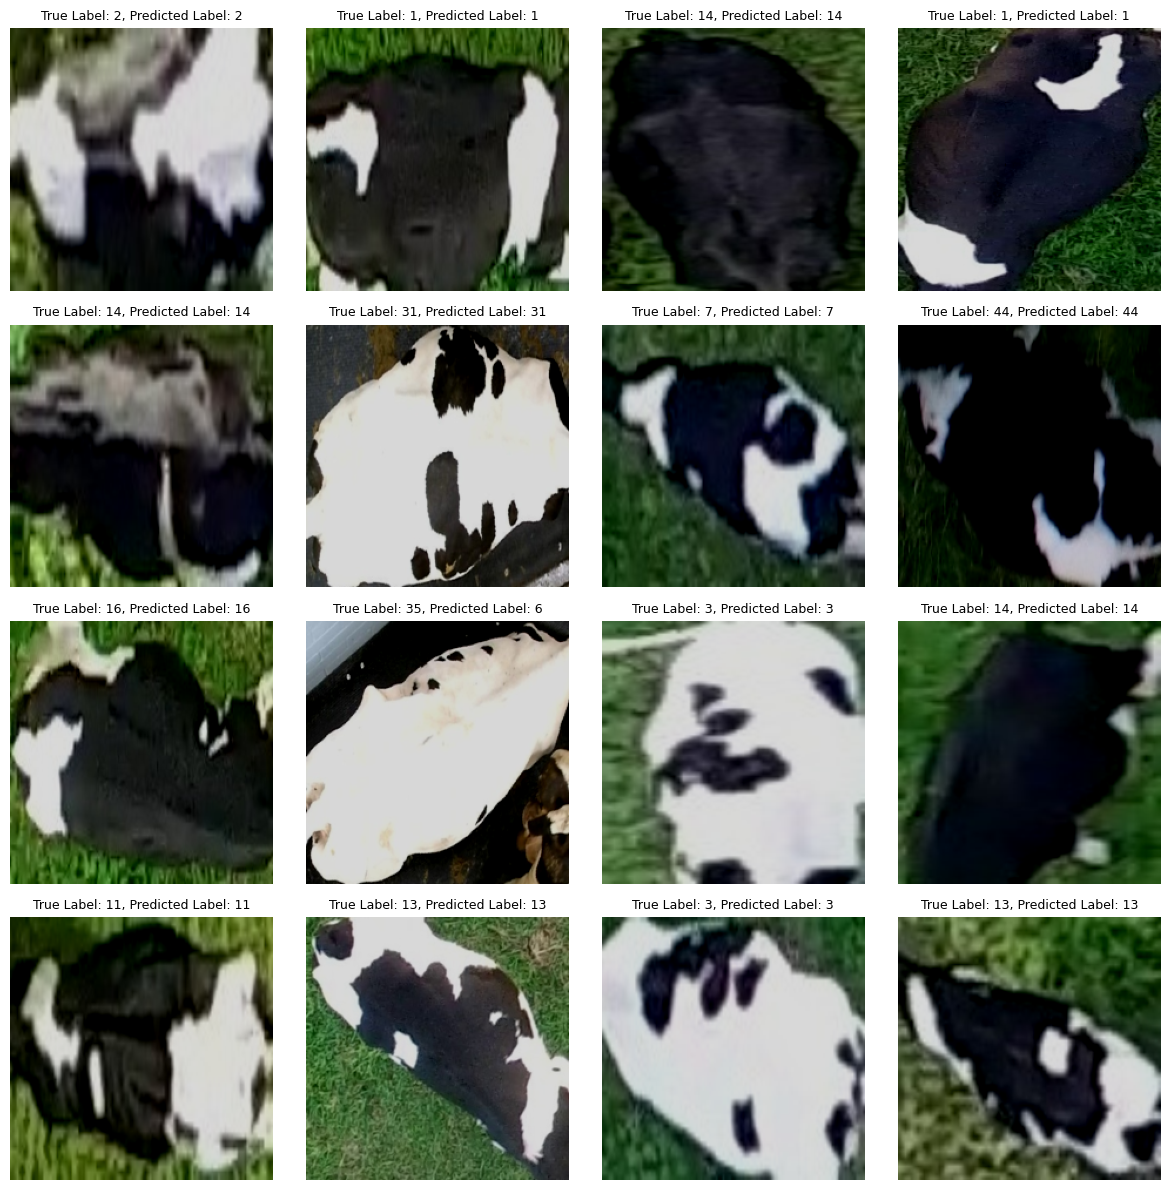

In [9]:
# Get 16 images and their corresponding labels from the test loader
test_dataset = ImageFolder(root=test_data_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(test_dataloader))

# Move the images to the appropriate device
images = images.to(device)

# Make predictions using the model
predictions = []
with torch.no_grad():
    outputs = beit(images)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.cpu().numpy())

# Plot the images with true and predicted labels
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images.cpu()[i].permute(1, 2, 0))
    plt.title(f"True Label: {labels[i]}, Predicted Label: {predictions[i]}", size = 9)
    plt.axis('off')
plt.tight_layout()
plt.show()

# THANKYOU